In [3]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
import torch.nn as nn
import collections
import torch.utils.data as data
import matplotlib.pyplot as plt
import lime.lime_tabular

In [4]:
df = pd.read_csv('SBAnational.csv')
df.head()

/home/tteofili/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [5]:
bad_columns = ['LoanNr_ChkDgt', 'NAICS', 'ApprovalDate', 'DisbursementDate', 'Name', 'FranchiseCode']
target = 'MIS_Status'
categorical = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc']
ordinal = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob']
money_columns = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
date_col = ['ChgOffDate']

In [6]:
# drop bad columns
df = df.dropna()
df = df.drop(columns=bad_columns)

In [7]:
# convert date to ordinal days
import datetime as dt
for c in date_col:
    df[c] = pd.to_datetime(df[c]).map(dt.datetime.toordinal)

In [8]:
# encode labels
le = sklearn.preprocessing.LabelEncoder()
df[target] = le.fit_transform(df[target].astype(str))
class_names = le.classes_
print(class_names)

['CHGOFF' 'P I F']


In [9]:
# process ordinal features
for col in ordinal:
    df[col] = pd.to_numeric(df['ApprovalFY'].replace('1976A','1976', regex=False).replace('\d+\-\w+\-\d+|,','', regex=True))
    df[col] = df[col].astype('int32')

In [10]:
# process money columns
for c in money_columns:
    df[c] = df[c].replace('\$|,','', regex=True).replace('\(','-', regex=True).replace('\)','', regex=True)
    df[c] = pd.to_numeric(df[c])

In [11]:
# process categorical features
cat_idxs = [df.columns.get_loc(c) for c in categorical if c in df]
print(cat_idxs)
categorical_names = {}
for c in categorical:
    le = preprocessing.LabelEncoder()
    df[c] = le.fit_transform(df[c])
    categorical_names[c] = le.classes_

[0, 1, 2, 3, 4, 8, 11, 12, 13]


In [12]:
Y = df[target]
X = df.drop(columns=[target])

# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [13]:
df.head()

,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
6,13801,31,1398,3393,43,1980,1980,1980,2,1980,...,0,2,3,727007,600000.0,0.0,0,208959.0,600000.0,499998.0
36,6727,35,8859,930,36,1997,1997,1997,1,1997,...,0,2,6,730958,47000.0,0.0,0,14084.0,47000.0,37600.0
43,3773,15,9249,1987,16,1980,1980,1980,2,1980,...,0,5,3,726379,197485.0,0.0,0,44374.0,200000.0,150000.0
58,2311,21,933,3393,43,2006,2006,2006,1,2006,...,1,0,3,735410,1350000.0,0.0,0,1043508.0,1350000.0,1012500.0
60,13187,22,10131,3393,43,1997,1997,1997,1,1997,...,0,0,3,732223,25000.0,0.0,0,23484.0,25000.0,12500.0


In [14]:
# create classifier model
class ClassifierModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(collections.OrderedDict([
            ('linear1', nn.Linear(20, 100)),
            ('tanh1', nn.Tanh()),
            ('dropout', nn.Dropout(0.5)),
            ('linear2', nn.Linear(100, 25)),
            ('tanh2', nn.Tanh()),
            ('linear3',nn.Linear(25, 1)),
            ('sigmoid', nn.Sigmoid())
        ]))

    def forward(self, x):
        return self.classifier(x)

In [16]:
# create tensors for training and test data
Xtr = torch.tensor(np.stack([X_train[col].values for col in X_train], 1),dtype=float).float()
Xtst = torch.tensor(np.stack([X_test[col].values for col in X_test], 1),dtype=float).float()
Ytr = torch.tensor(Y_train.values,dtype=float).unsqueeze(1).float()
Ytst = torch.tensor(Y_test.values,dtype=float).unsqueeze(1).float()

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    module=ClassifierModel,
    max_epochs=10,
    lr=0.01,
    criterion=nn.BCELoss,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

net.fit(Xtr, Ytr)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.1554       0.9694        0.1382  2.5281
      2        0.1373       0.9694        0.1378  2.7886
      3        0.1369       0.9694        0.1368  2.5062
      4        0.1369       0.9694        0.1379  2.6419
      5        0.1377       0.9694        0.1371  2.9452
      6        0.1373       0.9694        0.1372  2.6286
      7        0.1372       0.9694        0.1372  2.6425
      8        0.1368       0.9694        0.1368  2.6027
      9        0.1370       0.9694        0.1373  3.8019
     10        0.1370       0.9694        0.1371  2.8765


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModel(
    (classifier): Sequential(
      (linear1): Linear(in_features=20, out_features=100, bias=True)
      (tanh1): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
      (linear2): Linear(in_features=100, out_features=25, bias=True)
      (tanh2): Tanh()
      (linear3): Linear(in_features=25, out_features=1, bias=True)
      (sigmoid): Sigmoid()
    )
  ),
)

In [25]:
y_proba = net.predict_proba(Xtst)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
out = (torch.tensor(y_proba) > torch.tensor([0.5])).float() 

print(confusion_matrix(Ytst,out))
print(classification_report(Ytst,out))
print(accuracy_score(Ytst, out))

[[31232     0]
 [  943     0]]
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     31232
         1.0       0.00      0.00      0.00       943

    accuracy                           0.97     32175
   macro avg       0.49      0.50      0.49     32175
weighted avg       0.94      0.97      0.96     32175

0.9706915306915307


/home/tteofili/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


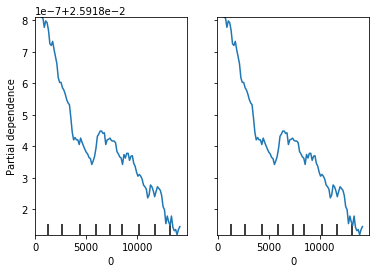

In [36]:
from sklearn.inspection import plot_partial_dependence
features = [0, (0)]
plot_partial_dependence(net, Xtr.numpy(), features)